In [1]:
import numpy as np
from scipy.linalg import block_diag
from SBB2MILP import *
import cvxpy as cp
import itertools
import time
from scipy.sparse import csr_matrix, hstack, vstack, csc_matrix
from mosek.fusion import *
import sys
#import seaborn as sns
#sns.set_style("white")

In [2]:
class Sub_problem:
    def __init__(self, p_id, q_id, indexer,indexer_coup, A, b, A_coup, b_coup, c, orig_length_beta):#, A, b, A_coup, b_coup):
        self.p_id = p_id
        self.q_id = q_id
        self.indexer = {**indexer, **indexer_coup}
        self.n = A.shape[1]
        self.orig_length_beta = orig_length_beta
        self.set_loc(A,b)
        self.set_cpl(A_coup, b_coup, c)
        self.initialise_dual()
    def set_loc(self, A, b):
        lbh, ubh = self.indexer[self.p_id]['height_loc']
        self.A_loc = {}
        self.b_loc = {}
        self.A_loc[self.p_id] = A[lbh:ubh]#csr_matrix(A[lbh:ubh])
        self.b_loc[self.p_id] = b[lbh:ubh]
        self.A_loc[self.p_id] = Matrix.sparse(self.A_loc[p_id].shape[0], self.n, list(self.A_loc[self.p_id].tocoo().row), list(self.A_loc[self.p_id].tocoo().col), list(self.A_loc[self.p_id].tocoo().data))
        lbh, ubh = self.indexer[self.q_id]['height_loc']
        self.A_loc[self.q_id] = A[lbh:ubh]#csr_matrix(A[lbh:ubh])
        self.b_loc[self.q_id] = b[lbh:ubh]
        self.A_loc[self.q_id] = Matrix.sparse(self.A_loc[q_id].shape[0], self.n, list(self.A_loc[self.q_id].tocoo().row), list(self.A_loc[self.q_id].tocoo().col), list(self.A_loc[self.q_id].tocoo().data))
    
    def set_cpl(self, A_coup, b_coup, c):
        lbh, ubh = 0,0
        
        #problems q to p and p to q will have symmetrical parameters
        pq = None
        if str(self.p_id)+','+str(self.q_id) in self.indexer:
            pq = str(self.p_id)+','+str(self.q_id)
        else:
            pq = str(self.q_id)+','+str(self.p_id)
        
        lbw, ubw = self.indexer[pq]['width']
        self.gamma = {}
        self.gamma[self.p_id] = np.zeros( (ubw-lbw, self.n) )
        self.gamma[self.q_id] = np.zeros( (ubw-lbw, self.n) )
        #for i,j in enumerate(range(lbw, ubw)):
        #    self.gamma[p_id][i, j] = 1
        #    self.gamma[q_id][i, j + orig_length_beta] = 1
        
        
        l = []
        u = []

        lbh, ubh = self.indexer[pq]['height'] 
        relevant_rows = A_coup[lbh:ubh]
        self.b_cpl = b_coup[lbh:ubh]
        
        lbw, ubw = self.indexer[self.p_id]['width_loc']
        A_pq = relevant_rows[:,lbw:ubw]
        l.append(lbw)
        u.append(ubw)
        
        
        lbw, ubw = self.indexer[self.q_id]['width_loc']
        A_qp = relevant_rows[:,lbw:ubw]
        l.append(lbw)
        u.append(ubw)
        
        lbw, ubw = self.indexer[pq]['width']
        R = relevant_rows[:,lbw:]
        my_hstack = np.hstack if type(A_pq) == np.ndarray else hstack
        my_vstack = np.vstack if type(A_pq) == np.ndarray else vstack
        #R = my_hstack(())
        l.append(lbw)
        u.append(ubw)
        h,w = relevant_rows.shape
        self.A_pq = A_pq
        self.A_qp = A_qp
        self.c={self.p_id : c.copy(), self.q_id : c.copy()}
        self.A_coup={}
        #check ordering of submatrices
        if l[1]>l[0]:
            self.c[self.p_id][:l[0]] = 0
            self.c[self.p_id][u[0]:] = 0
            self.c[self.q_id][:l[1]] = 0
            self.c[self.q_id][u[1]:] = 0
            self.A_coup[self.p_id] = my_hstack((  np.zeros( (h,l[0]) ), A_pq,  np.zeros( (h, l[1]-u[0]) ), np.zeros(A_qp.shape), np.zeros( (h, l[2]-u[1]) ), 0.5*R     ))
            self.A_coup[self.q_id] = my_hstack((  np.zeros( (h,l[0]) ), np.zeros(A_pq.shape),  np.zeros( (h, l[1]-u[0]) ), A_qp, np.zeros( (h, l[2]-u[1]) ), 0.5*R    ))
        else:
            l.sort()
            u.sort()
            self.c[self.p_id][:l[1]] = 0
            self.c[self.p_id][u[1]:] = 0
            self.c[self.q_id][:l[0]] = 0
            self.c[self.q_id][u[0]:] = 0
            self.A_coup[self.p_id] = my_hstack((  np.zeros( (h,l[0]) ), A_pq,  np.zeros( (h, l[1]-u[0]) ), np.zeros(A_qp.shape), np.zeros( (h, l[2]-u[1]) ), 0.5*R     ))
            self.A_coup[self.q_id] = my_hstack((  np.zeros( (h,l[0]) ), np.zeros(A_pq.shape),  np.zeros( (h, l[1]-u[0]) ), A_qp, np.zeros( (h, l[2]-u[1]) ), 0.5*R     ))
        self.m = {p_id: self.A_coup[self.p_id].shape[0], q_id: self.A_coup[self.q_id].shape[0]}
        A_coup
        self.A_coup[self.p_id] = Matrix.sparse(self.m[p_id], self.n, list(self.A_coup[self.p_id].tocoo().row), list(self.A_coup[self.p_id].tocoo().col), list(self.A_coup[self.p_id].tocoo().data))
        self.A_coup[self.q_id] = Matrix.sparse(self.m[q_id], self.n, list(self.A_coup[self.q_id].tocoo().row), list(self.A_coup[self.q_id].tocoo().col), list(self.A_coup[self.q_id].tocoo().data))
    def initialise_dual(self):
        self.dual = {}
        self.dual[self.p_id] = np.zeros(self.m[p_id])
        self.dual[self.q_id] = np.zeros(self.m[q_id])
        self.dual2 = {}
        self.dual2[self.p_id] = np.zeros(self.gamma[self.p_id].shape[0])
        self.dual2[self.q_id] = np.zeros(self.gamma[self.q_id].shape[0])

In [8]:
problem_name = 'problem_instances/sample_scenario.json'
A, b, A_coup, b_coup, c, indexer, indexer_coup, bool_idx, beta_idx,  service_intentions, TL, paths, get_index_by_delta, Lats = load_problem(problem_name)

Constructing graph for service intention 111
Constructing graph for service intention 113


In [9]:
A = csr_matrix(A)
A_coup = csr_matrix(A_coup)
beta_start = min(beta_idx)
orig_length_beta = len(beta_idx)

my_hstack = np.hstack if type(A) == np.ndarray else hstack
my_vstack = np.vstack if type(A) == np.ndarray else vstack

#A_coup = my_hstack((A_coup, A_coup[:, beta_start:]))
#A = my_hstack((A, np.zeros( (len(A),len(beta_idx)) )))
#c = my_hstack((c,np.zeros(len(beta_idx))))

m1, n = A.shape


#beta_idx+=beta_idx+[i+beta_idx[-1] for i in range(1,len(beta_idx)+1)]


service_intentions = [si for si in service_intentions]
bool_vars_idx = [(x,) for x in bool_idx]
coupling = [key for key in indexer_coup]
problems = service_intentions.copy()
S_sol = {p:np.ones(n) for p in problems} #{lam_p for p in problems}, initial setup should be empty,
                                            #but zeros equates to empty due to arithmetic
subsubproblems = {}
rho = 1
At = my_vstack((A,A_coup))
bt = np.hstack((b,b_coup))
## precompute coupling matrices
#np.random.shuffle(problems)
for i,idx in enumerate(indexer_coup):
    percentage = int(i/len(indexer_coup)*100)
    if percentage % 10 ==0:
        print(percentage)
    p_id = int(idx.split(',')[0])
    q_id = int(idx.split(',')[1])
    p = Sub_problem(p_id,q_id, indexer,indexer_coup, A, b, A_coup, b_coup, c, orig_length_beta)
    subsubproblems[str(p_id)+','+str(q_id)] = p
for i in subsubproblems:
    S_sol = {p:np.ones(n) for p in problems}

0


In [10]:
#def solve_mosek(At, b, bool_idx):
from mosek.fusion import *
import sys

with Model() as M:
    At = Matrix.sparse(list(At.tocoo().row), list(At.tocoo().col), list(At.tocoo().data))

    #
    x = M.variable('x',  n  , Domain.greaterThan(0.0))#Domain.binary())
    for idx in bool_idx:
        x.index(idx).makeInteger()
        M.constraint(x.index(idx), Domain.lessThan(1.5))
        
    
    M.constraint('c1', Expr.mul(At, x), Domain.lessThan(bt))
    print(x.getShape())
    # Set the objective function to (c^T * x)
    M.objective('obj', ObjectiveSense.Minimize, Expr.dot(c, x))

    t0 = time.time()
    #M.setLogHandler(sys.stdout)
    M.solve()
    print(time.time() - t0)

    ss = M.getPrimalSolutionStatus()
    print("Solution status: {0}".format(ss))
    sol = x.level()



    constr = M.getSolverIntInfo("mioConstructSolution")
    constrVal = M.getSolverDoubleInfo("mioConstructSolutionObj")
    #print("Initial solution utilization: {0}\nInitial solution objective: {1:.3f}\n".format(constr, constrVal))    

[318]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 2213            
  Cones                  : 0               
  Scalar variables       : 319             
  Matrix variables       : 0               
  Integer variables      : 46              

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.02
Presolved problem: 188 variables, 1583 constraints, 7188 non-zeros
Presolved problem: 0 general integer, 18 binary, 170 continuous
Clique table size: 2
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   0.0000000000e+00     NA          0.1   
0        1        1        0        0.0000000000e+00     0.0000000000e+00     0.00e+00    0.1   
An optimal solution satisfying the relative gap toleran

x = cp.Variable(n, boolean = bool_vars_idx)

prob = cp.Problem(cp.Minimize(c.T@x),
                 [vstack((A, A_coup))@x<=np.hstack((b,b_coup))])#, s>=0, s>=E_p])
prob = prob.solve(solver = 'MOSEK', verbose = True)

si: 111, edge: (1_beginning),(M1), tin: 08:25:03, tout: 08:25:56
si: 111, edge: (M1),(4->5), tin: 08:25:56, tout: 08:26:28
si: 111, edge: (4->5),(M2), tin: 08:26:28, tout: 08:30:00
si: 111, edge: (M2),(M3), tin: 08:30:00, tout: 08:30:32
si: 111, edge: (M3),(10->13), tin: 08:30:32, tout: 08:31:04
si: 111, edge: (10->13),(M4), tin: 08:31:04, tout: 08:49:28
si: 111, edge: (M4),(14_end), tin: 08:49:28, tout: 08:50:00
si: 113, edge: (3_beginning),(M1), tin: 07:50:00, tout: 07:50:53
si: 113, edge: (M1),(4->5), tin: 07:50:53, tout: 07:51:25
si: 113, edge: (4->5),(M2), tin: 07:51:25, tout: 07:51:57
si: 113, edge: (M2),(7->8), tin: 07:51:57, tout: 07:52:29
si: 113, edge: (7->8),(8->9), tin: 07:52:29, tout: 07:53:01
si: 113, edge: (8->9),(9_end), tin: 07:53:01, tout: 08:16:00


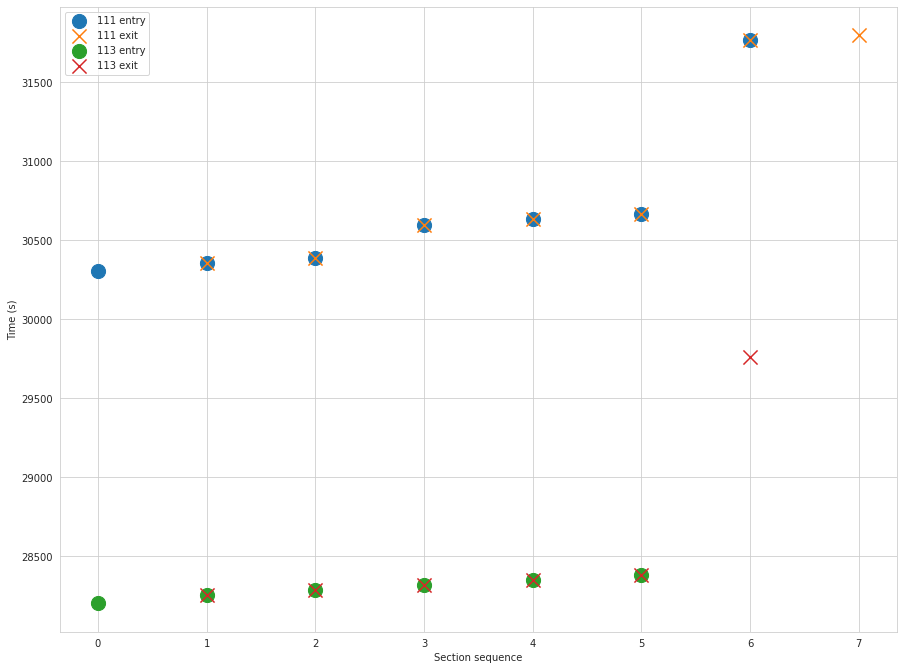

In [11]:
display_solution(sol,service_intentions, TL, paths, get_index_by_delta, Lats)

In [37]:
t0 = time.time()
max_iter = 10
errors = []

currbest = np.inf
iter_since_best = 0
max_iter_since_best = 10
tolerance = 0
dt = 0
tsum = 0
for i in range(max_iter):
    print(f'-----------[Iteration {i+1}]-------------------')
    #np.random.shuffle(problems)
    for p_id in problems:
        with Model() as M:


            lam_p = M.variable('x',  n  , Domain.greaterThan(0.0))#Domain.binary())

            for idx in bool_idx:
                lam_p.index(idx).makeInteger()
                M.constraint(lam_p.index(idx), Domain.lessThan(1.5))

            Jp = 0
            tsum0 = time.time()
            #load sum function
            for q_id in problems:
                if str(p_id)+','+str(q_id) in subsubproblems or str(q_id)+','+str(p_id) in subsubproblems: #problems coupled to p
                    found = True
                    spi = str(p_id)+','+str(q_id)
                    if str(p_id)+','+str(q_id) not in subsubproblems:
                        spi = str(q_id)+','+str(p_id)
                    tp = subsubproblems[spi]
                    c = subsubproblems[spi].c[p_id]
                    A_loc = subsubproblems[spi].A_loc[p_id]
                    b_loc = subsubproblems[spi].b_loc[p_id]
                    lam_qt = S_sol[q_id]
                    lam_q = M.parameter(f'lam_{p_id},{q_id}', len(lam_qt))
                    lam_q.setValue(lam_qt)
                    b_cpl = M.parameter(f'b_{p_id},{q_id}', len(tp.b_cpl))
                    b_cpl.setValue(tp.b_cpl)

                    slack1 = M.variable(f's_{p_id},{q_id}',  tp.m[p_id] , Domain.greaterThan(0.0))
                    Epq = Expr.add( Expr.mul(tp.A_coup[p_id], lam_p) , Expr.sub(Expr.mul(tp.A_coup[q_id],lam_q) , b_cpl))
                    #Gpq = Expr.sub( Expr.mul(tp.gamma[p_id], lam_p), tp.gamma[q_id]@lam_q   )
                    M.constraint(f'slack_{p_id},{q_id}', Expr.sub(slack1, Epq ) , Domain.greaterThan(0.0))
                    Jp = Expr.add(Jp, Expr.dot(tp.dual[p_id],slack1))
                    #Jp = Expr.add(Jp, Expr.dot(tp.dual2[p_id], Gpq))

                    I = np.identity(len(tp.dual[p_id]))*0.5*rho
                    t = M.variable(f"t_{p_id},{q_id}", 1, Domain.unbounded())
                    M.constraint(f'cone_{p_id},{q_id}', Expr.vstack(t, 0.5, Expr.mul(I,slack1)), Domain.inRotatedQCone())
                    Jp = Expr.add(Jp, t)

                    #I = np.identity(len(tp.dual2[p_id]))*0.5*rho
                    #t2 = M.variable(f"t2_{p_id},{q_id}", 1, Domain.unbounded())
                    #M.constraint(f'cone2_{p_id},{q_id}', Expr.vstack(t2, 0.5, Expr.mul(I,Gpq)), Domain.inRotatedQCone())
                    #Jp = Expr.add(Jp, t2)
            #load total objective
            Jp = Expr.add( Expr.dot(c, lam_p), Jp)

            tsum += time.time() - tsum0
            M.constraint('local', Expr.mul(A_loc, lam_p), Domain.lessThan(b_loc))
            # Set the objective function to (c^T * x)
            M.objective('obj', ObjectiveSense.Minimize, Jp)

            # Solve the problem
            #M.setLogHandler(sys.stdout)
            ttemp = time.time()
            M.solve()
            dtt = time.time() - ttemp
            dt+=dtt
            # Get the solution values
            ss = M.getPrimalSolutionStatus()
            print("Solution status: {0}".format(ss))
            sol = lam_p.level()
            lam_p = lam_p.level()
            #print('x = {0}'.format(sol))

            # Was the initial solution used?
            constr = M.getSolverIntInfo("mioConstructSolution")
            constrVal = M.getSolverDoubleInfo("mioConstructSolutionObj")
            #print("Initial solution utilization: {0}\nInitial solution objective: {1:.3f}\n".format(constr, constrVal))    
        S_sol[p_id] = lam_p
    #update dual variables
    pinf = []
    for p_id in problems:
        for q_id in problems:
            if str(p_id)+','+str(q_id) in subsubproblems or str(q_id)+','+str(p_id) in subsubproblems:
                spi = str(p_id)+','+str(q_id)
                if str(p_id)+','+str(q_id) not in subsubproblems:
                    spi = str(q_id)+','+str(p_id)
                tp = subsubproblems[spi]
                lam_p = S_sol[p_id]
                lam_q = S_sol[q_id]
                Epq = tp.A_coup[p_id].getDataAsArray().reshape(tp.m[p_id], tp.n)@lam_p + tp.A_coup[q_id].getDataAsArray().reshape(tp.m[q_id], tp.n)@lam_q - tp.b_cpl
                Epq[Epq<0] = 0
                subsubproblems[spi].dual[p_id] += rho*Epq
                pinf += [np.linalg.norm(Epq, np.inf)]


    pinf = max(pinf)
            #print(subsubproblems[str(p_id)+','+str(q_id)].dual)
    iter_since_best += 1
    if pinf>currbest:
        currbest = pinf
        iter_since_best = 0
    if iter_since_best > max_iter_since_best:
        print('no improvements. halfing ascent speed')
        rho /= 2
        iter_since_best = 0

    print(f'infinity norm: {pinf}')
    errors.append(pinf)
    if pinf <= tolerance:
        break


tf = time.time()
print('time taken for ADMM: ', tf-t0)
print('time taken for solver:', dtt)
print('time taken for summation:', tsum)


-----------[Iteration 1]-------------------
Solution status: SolutionStatus.Optimal
Solution status: SolutionStatus.Optimal
Solution status: SolutionStatus.Optimal
Solution status: SolutionStatus.Optimal
infinity norm: 0.0
time taken for ADMM:  4.069278240203857
time taken for solver: 0.09600067138671875
time taken for summation: 3.1665499210357666


si: 18823, edge: (1_beginning),(1->5), tin: 06:35:00, tout: 06:37:00
si: 18823, edge: (1->5),(5->10), tin: 06:37:00, tout: 06:41:09
si: 18823, edge: (5->10),(10->15), tin: 06:41:09, tout: 06:41:17
si: 18823, edge: (10->15),(15->20), tin: 06:41:17, tout: 06:41:31
si: 18823, edge: (15->20),(20->25), tin: 06:41:31, tout: 06:41:51
si: 18823, edge: (20->25),(25->30), tin: 06:41:51, tout: 06:42:11
si: 18823, edge: (25->30),(30->35), tin: 06:42:11, tout: 06:42:22
si: 18823, edge: (30->35),(35->37), tin: 06:42:22, tout: 06:42:36
si: 18823, edge: (35->37),(37->40), tin: 06:42:36, tout: 06:43:10
si: 18823, edge: (37->40),(40->45), tin: 06:43:10, tout: 06:43:54
si: 18823, edge: (40->45),(45->50), tin: 06:43:54, tout: 06:44:14
si: 18823, edge: (45->50),(50->52), tin: 06:44:14, tout: 06:44:34
si: 18823, edge: (50->52),(52->55), tin: 06:44:34, tout: 06:45:08
si: 18823, edge: (52->55),(55->60), tin: 06:45:08, tout: 06:45:55
si: 18823, edge: (55->60),(60->65), tin: 06:45:55, tout: 06:46:25
si: 18823, 

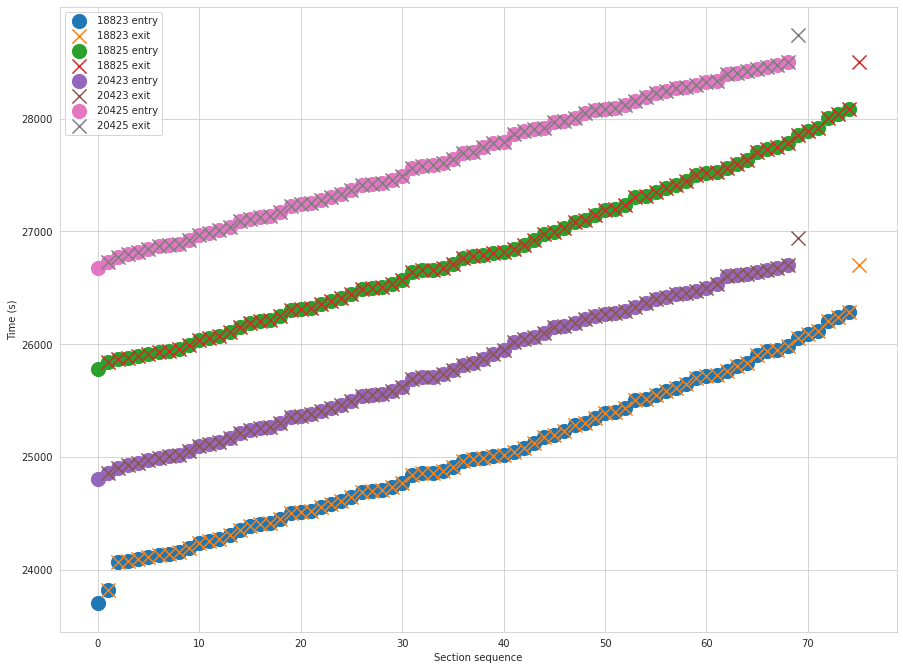

In [38]:
x = lam_p
for si in service_intentions:
    lb, ub = indexer[si]['width_loc']
    x[lb:ub] = S_sol[si][lb:ub]
display_solution(x,service_intentions, TL, paths, get_index_by_delta, Lats)

si: 18823, edge: (1_beginning),(1->5), tin: 06:35:00, tout: 06:37:00
si: 18823, edge: (1->5),(5->10), tin: 06:37:00, tout: 06:41:09
si: 18823, edge: (5->10),(10->15), tin: 06:41:09, tout: 06:41:17
si: 18823, edge: (10->15),(15->20), tin: 06:41:17, tout: 06:41:31
si: 18823, edge: (15->20),(20->25), tin: 06:41:31, tout: 06:41:51
si: 18823, edge: (20->25),(25->30), tin: 06:41:51, tout: 06:42:11
si: 18823, edge: (25->30),(30->35), tin: 06:42:11, tout: 06:42:22
si: 18823, edge: (30->35),(35->37), tin: 06:42:22, tout: 06:42:36
si: 18823, edge: (35->37),(37->40), tin: 06:42:36, tout: 06:43:10
si: 18823, edge: (37->40),(40->45), tin: 06:43:10, tout: 06:43:54
si: 18823, edge: (40->45),(45->50), tin: 06:43:54, tout: 06:44:14
si: 18823, edge: (45->50),(50->52), tin: 06:44:14, tout: 06:44:34
si: 18823, edge: (50->52),(52->55), tin: 06:44:34, tout: 06:45:08
si: 18823, edge: (52->55),(55->60), tin: 06:45:08, tout: 06:45:55
si: 18823, edge: (55->60),(60->65), tin: 06:45:55, tout: 06:46:25
si: 18823, 

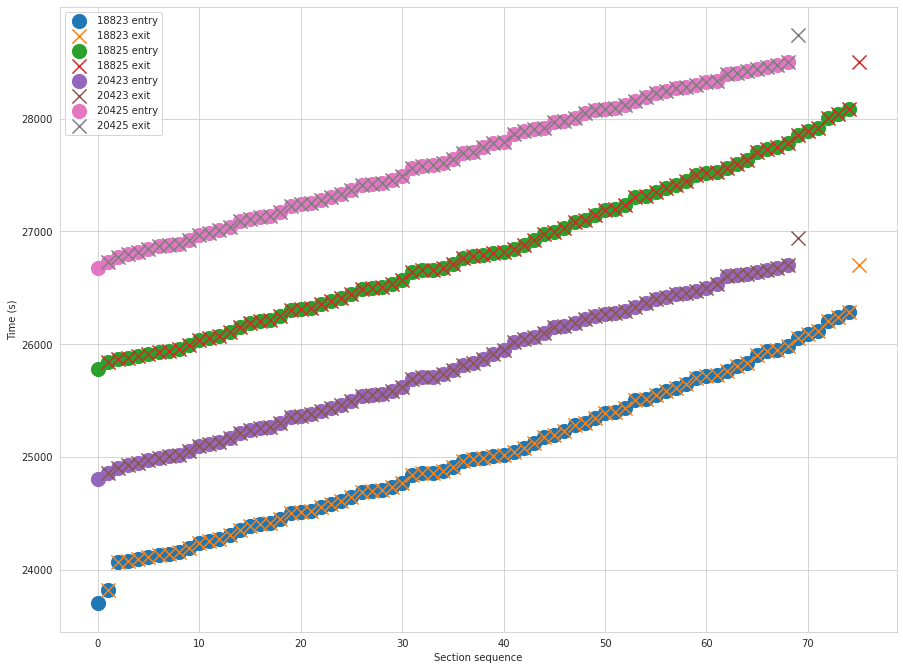

In [62]:
x = lam_p
for si in service_intentions:
    lb, ub = indexer[si]['width_loc']
    x[lb:ub] = S_sol[si][lb:ub]
display_solution(x,service_intentions, TL, paths, get_index_by_delta, Lats)

In [69]:
bool_idx

[1062,
 1063,
 1064,
 1065,
 1066,
 1067,
 1068,
 1069,
 1070,
 1071,
 1072,
 1073,
 1074,
 1075,
 1076,
 1077,
 1078,
 1079,
 1080,
 1081,
 1082,
 1083,
 1084,
 1085,
 1086,
 1087,
 1088,
 1089,
 1090,
 1091,
 1092,
 1093,
 1094,
 1095,
 1096,
 1097,
 1098,
 1099,
 1100,
 1101,
 1102,
 1103,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1118,
 1119,
 1120,
 1121,
 1122,
 1123,
 1124,
 1125,
 1126,
 1127,
 1128,
 1129,
 1130,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,
 1137,
 1138,
 1139,
 1140,
 1141,
 695,
 696,
 697,
 698,
 699,
 700,
 701,
 702,
 703,
 704,
 705,
 706,
 707,
 708,
 709,
 710,
 711,
 712,
 713,
 714,
 715,
 716,
 717,
 718,
 719,
 720,
 721,
 722,
 723,
 724,
 725,
 726,
 727,
 728,
 729,
 730,
 731,
 732,
 733,
 734,
 735,
 736,
 737,
 738,
 739,
 740,
 741,
 742,
 743,
 744,
 745,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 753,
 754,
 755,
 756,
 757,
 758,
 759,
 760,
 761,
 762,
 763,
 764,
 765,
 766,
 767,
 7

In [170]:
t0 = time.time()
max_iter = 1
errors = []

currbest = np.inf
iter_since_best = 0
max_iter_since_best = 10
tolerance = 0

for i in range(max_iter):
    print(f'-----------[Iteration {i+1}]-------------------')
    #np.random.shuffle(problems)
    for p_id in problems:
        lam_p = cp.Variable(n, boolean = bool_vars_idx)
        found = False
        slacks = []
        cs = []
        Jp = 0
        for q_id in problems:
            if str(p_id)+','+str(q_id) in subsubproblems or str(q_id)+','+str(p_id) in subsubproblems: #problems coupled to p
                found = True
                spi = str(p_id)+','+str(q_id)
                if str(p_id)+','+str(q_id) not in subsubproblems:
                    spi = str(q_id)+','+str(p_id)
                tp = subsubproblems[spi]
                c = subsubproblems[spi].c[p_id]
                A_loc = subsubproblems[spi].A_loc[p_id]
                b_loc = subsubproblems[spi].b_loc[p_id]
                print(p_id, q_id)
                lam_q = S_sol[q_id]
                Epq = tp.A_coup[p_id]@lam_p + tp.A_coup[q_id]@lam_q - tp.b_cpl
                slack = cp.Variable(tp.m[p_id], nonneg = True)
                slacks.append(slack)
                cs.append( (slack>=Epq) )
                Jp += tp.dual[p_id].T@slack
                I = np.identity(len(tp.dual[p_id]))
                Jp += 0.5*rho*cp.quad_form(slack, I)
        if not found: #problem not coupled
            print(f'no coupling in {p_id}. skipping')
            break
        Z = c.T@lam_p
        Jp = 0
        print('z',Z)
        #drawmatrix(A_loc, 10)
        prob = cp.Problem(cp.Minimize(Z+Jp),
                         [A_loc@lam_p<=b_loc])#+cs)

        prob = prob.solve(solver = 'MOSEK', verbose = True)
        print(f'Objective at {p_id} = {prob}')
        #update solutions
        S_sol[p_id] = lam_p.value
        break
    
    #update dual variables
    pinf = 0
    for p_id in problems:
        for q_id in problems:
            if str(p_id)+','+str(q_id) in subsubproblems or str(q_id)+','+str(p_id) in subsubproblems:
                spi = str(p_id)+','+str(q_id)
                if str(p_id)+','+str(q_id) not in subsubproblems:
                    spi = str(q_id)+','+str(p_id)
                tp = subsubproblems[spi]
                lam_p = S_sol[p_id]
                lam_q = S_sol[q_id]
                Epq = tp.A_coup[p_id]@lam_p + tp.A_coup[q_id]@lam_q - tp.b_cpl
                pinf += np.linalg.norm(Epq, np.inf)
                #Epq[Epq<0] = 0
                subsubproblems[spi].dual[p_id] += rho*Epq
                
            
            #print(subsubproblems[str(p_id)+','+str(q_id)].dual)
    iter_since_best += 1
    if pinf>currbest:
        currbest = pinf
        iter_since_best = 0
    if iter_since_best > max_iter_since_best:
        print('no improvements. halfing ascent speed')
        rho /= 2
        iter_since_best = 0
        
    print(f'infinity norm: {pinf}')
    errors.append(pinf)
    if pinf <= tolerance:
        pass#break
    
            
tf = time.time()
print('time taken: ', tf-t0)

-----------[Iteration 1]-------------------
111 113


ValueError: Incompatible dimensions (1296, 346) (332, 1)

si: 111, edge: (3_beginning),(M1), tin: 08:20:00, tout: 08:20:53
si: 111, edge: (M1),(4->5), tin: 08:20:53, tout: 08:44:52
si: 111, edge: (4->5),(M2), tin: 08:44:52, tout: 08:48:24
si: 111, edge: (M2),(7->8), tin: 08:48:24, tout: 08:48:56
si: 111, edge: (7->8),(8->9), tin: 08:48:56, tout: 08:49:28
si: 111, edge: (8->9),(9_end), tin: 08:49:28, tout: 08:50:00
si: 113, edge: (3_beginning),(M1), tin: 07:50:00, tout: 07:50:53
si: 113, edge: (M1),(4->5), tin: 07:50:53, tout: 08:13:52
si: 113, edge: (4->5),(M2), tin: 08:13:52, tout: 08:14:24
si: 113, edge: (M2),(7->8), tin: 08:14:24, tout: 08:14:56
si: 113, edge: (7->8),(8->9), tin: 08:14:56, tout: 08:15:28
si: 113, edge: (8->9),(9_end), tin: 08:15:28, tout: 08:16:00


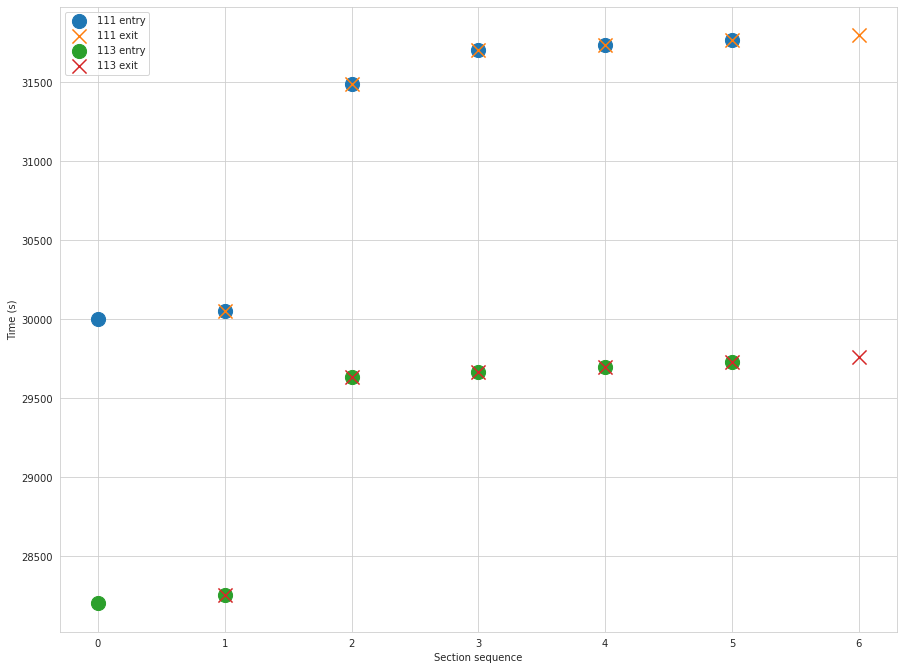

In [179]:
import pickle
file = open('dumps/experiment_LR.pickle', 'wb')
pickle.dump(S_sol, file)

In [186]:
x = lam_p
for si in service_intentions:
    lb, ub = indexer[si]['width_loc']
    x[lb:ub] = S_sol[si][lb:ub]
display_solution(x,service_intentions, TL, paths, get_index_by_delta, Lats)

si: 111, edge: (3_beginning),(M1), tin: 08:20:00, tout: 08:20:53
si: 111, edge: (M1),(4->5), tin: 08:20:53, tout: 08:21:25
si: 111, edge: (4->5),(M2), tin: 08:21:25, tout: 08:48:24
si: 111, edge: (M2),(7->8), tin: 08:48:24, tout: 08:48:56
si: 111, edge: (7->8),(8->9), tin: 08:48:56, tout: 08:49:28
si: 111, edge: (8->9),(9_end), tin: 08:49:28, tout: 08:50:00
si: 113, edge: (1_beginning),(M1), tin: 00:00:01, tout: 00:00:01
si: 113, edge: (M1),(4->5), tin: 00:00:01, tout: 00:00:01
si: 113, edge: (4->5),(M2), tin: 00:00:01, tout: 00:00:01
si: 113, edge: (M2),(M3), tin: 00:00:01, tout: 00:00:01
si: 113, edge: (M3),(10->13), tin: 00:00:01, tout: 00:00:01
si: 113, edge: (10->13),(M4), tin: 00:00:01, tout: 00:00:01
si: 113, edge: (M4),(14_end), tin: 00:00:01, tout: 00:00:01


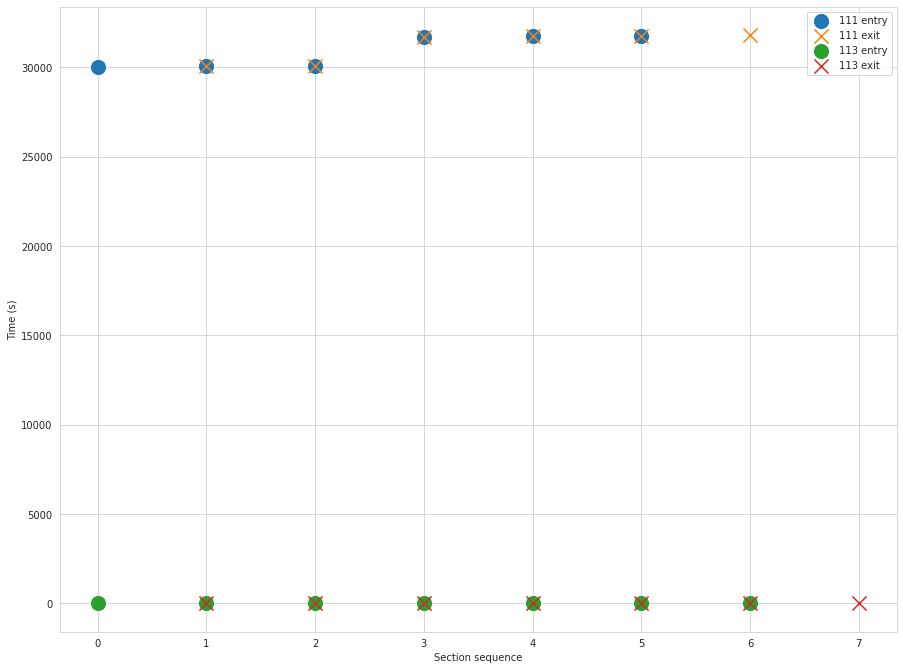

In [188]:
for si in service_intentions:
    lb, ub = indexer[si]['width_loc']
    x[lb:ub] = S_sol[si][lb:ub]
display_solution(x,service_intentions, TL, paths, get_index_by_delta, Lats)
display_solution(x,service_intentions, TL, paths, get_index_by_delta, Lats)